In [12]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import decimate

from audio import AudioDataset, AudioFile

test = AudioDataset('../data/raw/nsynth-test')
train = AudioDataset('../data/raw/nsynth-train')
guitar = AudioFile(*test.get_filepath('guitar_acoustic', 6))
piano = AudioFile(*train.get_filepath('keyboard_acoustic', 27))

In [213]:
def log_xscale(audiofile, spectrogram, ax, min_freq):
    max_freq = audiofile.nyquist
    min_idx = audiofile._log_to_logidx(audiofile._freq_to_log(min_freq))
    x_step = audiofile.fundamental_freq
    first_fundamental = audiofile.fundamental_freq * (1 + (min_freq//audiofile.fundamental_freq))
    nth_fundamental =  min(max_freq, first_fundamental+(x_step*10))
    xtick_freqs = range(first_fundamental, nth_fundamental+1, x_step)
    ax.set_xticks([audiofile._log_to_logidx(audiofile._freq_to_log(x)) - min_idx
                   for x in xtick_freqs])
    ax.set_xticklabels(xtick_freqs)

In [227]:
def plot_spectrogram(audiofile, spectrogram, ax, min_freq=1):
    min_idx = audiofile._log_to_logidx(audiofile._freq_to_log(min_freq))
    ax.plot(spectrogram[0][min_idx:])
    log_xscale(audiofile, spectrogram, ax, min_freq)
    ax.grid()
    print(spectrogram[0][min_idx:].shape)

In [228]:
def downsample(audiofile, resolution, scaling):
    downsampled = audiofile.spectrogram_log[0].copy()
    for i in range(scaling[0]):
        downsampled = decimate(downsampled, scaling[1])
    audiofile.spectrogram_log = downsampled.reshape(1, -1)
    audiofile.set_log_resolution(resolution//(scaling[1]**scaling[0]))

## Guitar

(1009,)
(1011,)
(126185,)


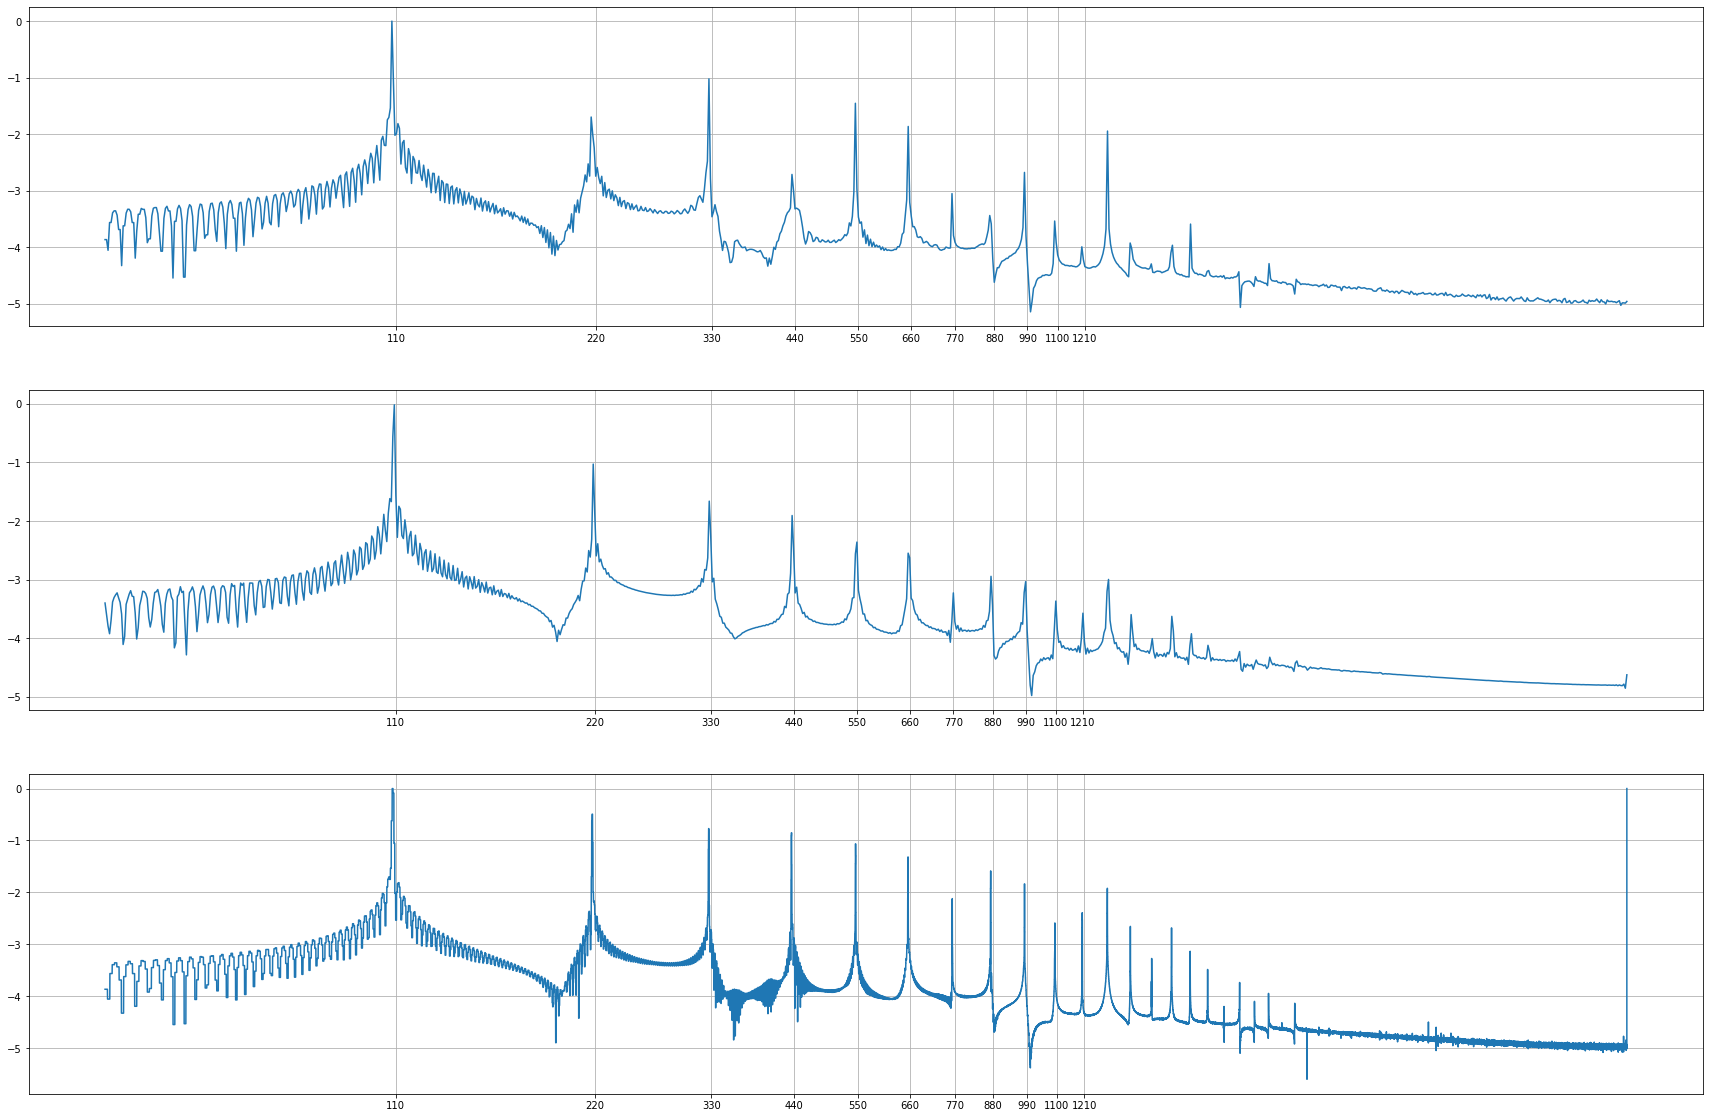

In [237]:
min_freq = 40
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Load audio and create spectrogram
guitar.trim_audio(start=0.5, end=3.5)
guitar.audio_to_spectrogram(spec_thresh=10)

# 100 resolution
resolution = 132
guitar.spectrogram_to_log(guitar.spectrogram, resolution=resolution)
plot_spectrogram(guitar, guitar.spectrogram_log, axes[0], min_freq)

# max resolution + downsampling with anti-aliasing
resolution = 16508
guitar.spectrogram_to_log(guitar.spectrogram, resolution=resolution)
downsample(guitar, resolution, scaling=(3, 5))
plot_spectrogram(guitar, guitar.spectrogram_log, axes[1], min_freq)

# max resolution
resolution = 16508
guitar.spectrogram_to_log(guitar.spectrogram, resolution=resolution)
plot_spectrogram(guitar, guitar.spectrogram_log, axes[2], min_freq)

## Piano

(1009,)
(1011,)
(126185,)


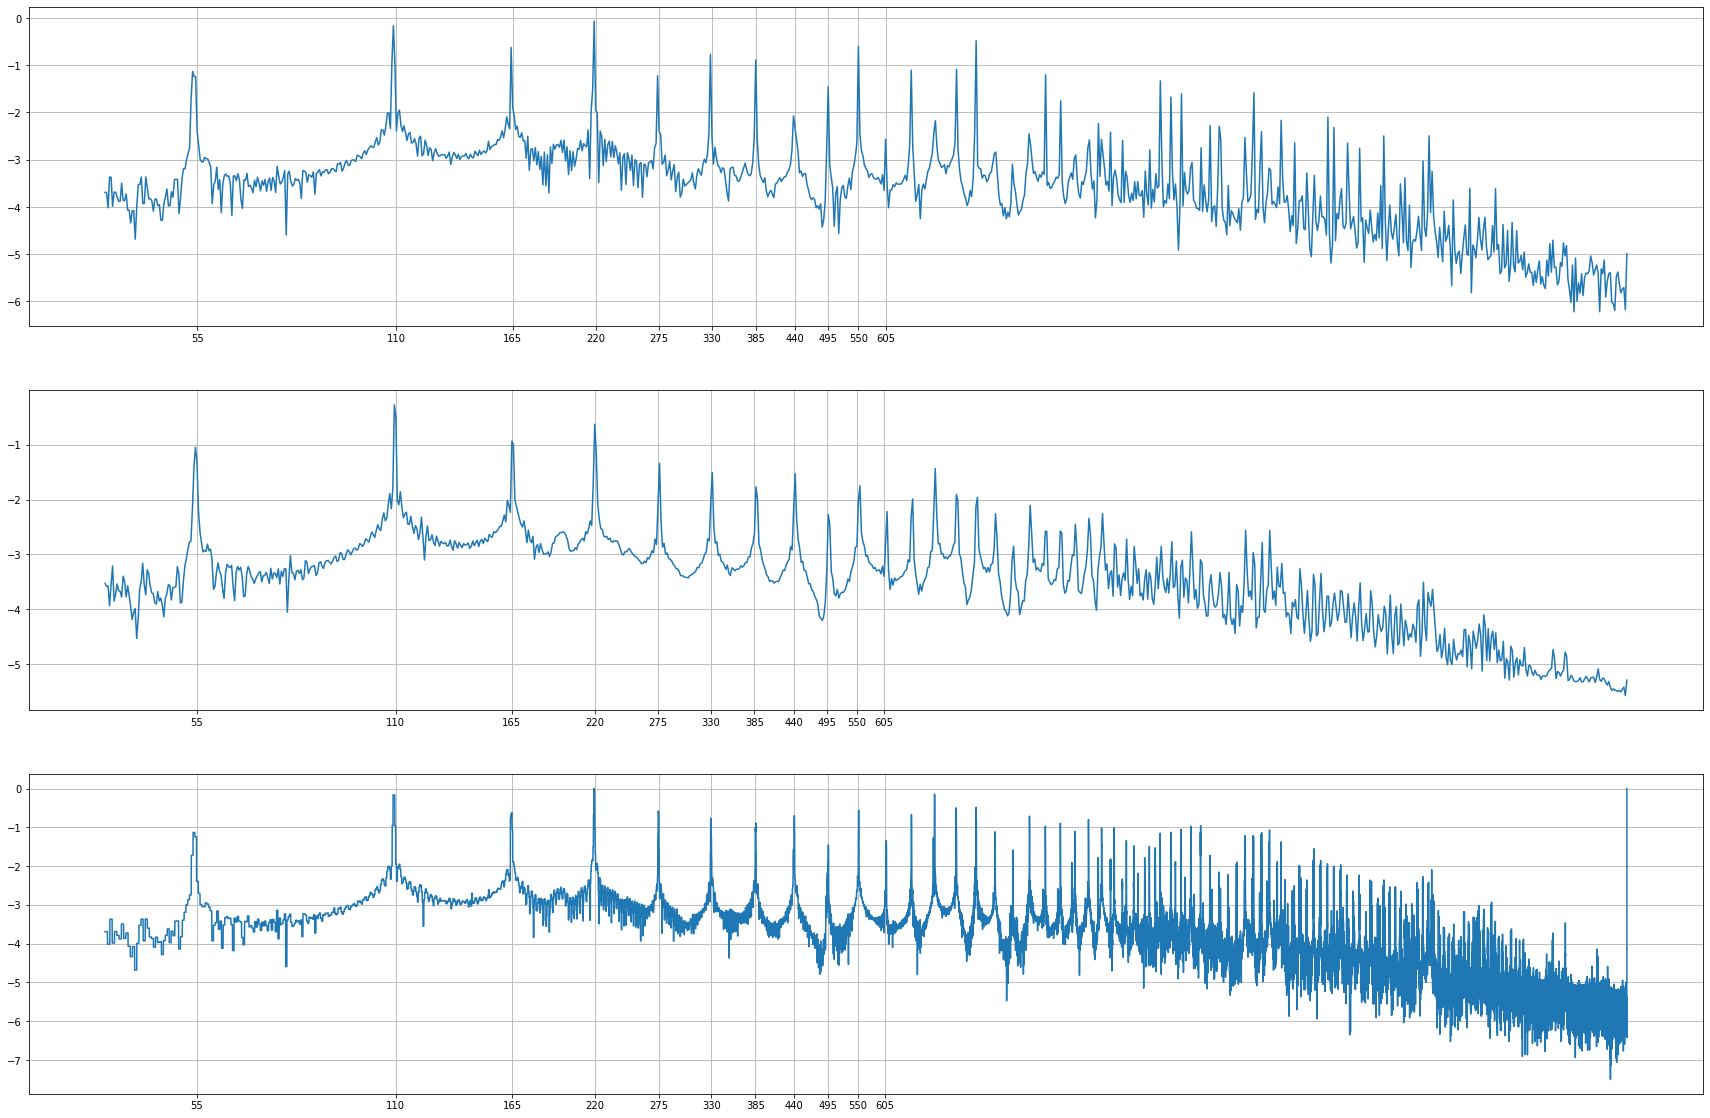

In [238]:
min_freq = 40
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Load audio and create spectrogram
piano.trim_audio(start=0.5, end=3.5)
piano.audio_to_spectrogram(spec_thresh=10)

# 100 resolution
resolution = 132
piano.spectrogram_to_log(piano.spectrogram, resolution=resolution)
plot_spectrogram(piano, piano.spectrogram_log, axes[0], min_freq)

# max resolution + downsampling with anti-aliasing
resolution = 16508
piano.spectrogram_to_log(piano.spectrogram, resolution=resolution)
downsample(piano, resolution, scaling=(3, 5))
plot_spectrogram(piano, piano.spectrogram_log, axes[1], min_freq)

# max resolution
resolution = 16508
piano.spectrogram_to_log(piano.spectrogram, resolution=resolution)
plot_spectrogram(piano, piano.spectrogram_log, axes[2], min_freq)